# Face Equipment Detection In The COVID-19 Era
The COVID-19 pandemic poses a number of challenges to the Artificial Intelligence
(AI) Community. One of the most popular challenge is face mask detection. AI can be
used to detect whether faces captured in the camera are wearing face mask or not in order
to enforce citizens to wear face mask whenever they are going out. This can be done by
simply training a deep learning model to classify a face detected as wearing or not wearing
mask and currently there are tons of studying works on internet. In this project, we take
the challenge one step further where we are not only detecting whether a face is wearing
or not wearing mask, we try to further break down the cases into more detail classes such
as whether a face is wearing a proper surgical mask or other type of masks, whether
people is wearing face shield or goggles and more to determine how much precautions a
person take to reduce the risk of being infected by COVID-19.

## Google Drive Mounting
Mount Google Drive to this notebook to access dataset and trained model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## External Library Installation
Install library needed that is not installed in Google Colab

In [2]:
!pip install pyshine

## Download Utility Functions
Download TorchVision repo to use some utility functions provided

In [3]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 28688, done.
remote: Counting objects: 100% (1233/1233), done.
remote: Compressing objects: 100% (429/429), done.
remote: Total 28688 (delta 882), reused 1094 (delta 781), pack-reused 27455
Receiving objects: 100% (28688/28688), 37.33 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (21497/21497), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


## Helper Function
Create a helper function to remove matplotlib x and y axis ticks

In [4]:
def remove_plot_axis(plt):
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
  plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

## Library Import
Import all libraries required

In [5]:
import cv2
import matplotlib.pyplot as plt
import sys
import pyshine as ps
import os
import json
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

Warning! No module named 'sounddevice'


## Target Class Selection
Select all classes relevant to this project's goal out of 20 classes from the dataset and assign an ID to every class.

In [6]:
class_dict = {'balaclava_ski_mask': 0, 
              'eyeglasses': 1, 
              'face_no_mask': 2, 
              'face_shield': 3, 
              'face_with_mask': 4, 
              'face_with_mask_incorrect': 5, 
              'gas_mask': 6, 
              'goggles': 7, 
              'mask_surgical': 8, 
              'scarf_bandana': 9}

selected_class = list(class_dict.keys())

# directory to dataset
root_dir = 'drive/MyDrive/Dataset/Medical Mask/Medical mask/Medical mask/Medical Mask/'

## Create Custom Dataset
Create a custom dataset (inherit PyTorch `Dataset` class) for Face Mask Detection Dataset from Kaggle  
Override `__getitem__` function so that it can be used for PyTorch Dataloader
1. read annotation file one by one
2. read the respective image file and convert it to tensor
3. retrieve every bounding box annotation with its repective class label
4. return tensor image and label pair

In [7]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # load images and annotations
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        with open(annotation_path,'r') as f:
          json_file = json.load(f)

        boxes = []
        labels = []
        num_objs = 0
        # get bounding box coordinates and class label for each objects (selected class only)
        for annotation in json_file.get("Annotations"):
          if annotation['classname'] in selected_class:
            xmin, ymin, xmax, ymax = annotation["BoundingBox"]
            boxes.append([xmin, ymin, xmax, ymax])
            a_label = class_dict[annotation['classname']]
            labels.append(a_label)
            num_objs += 1
        
        # convert annotations to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Download `TorchVision` Pretrained Model
1. Load pretrained `FasterRCNN` model from `TorchVision`
2. Replace the pretrained predictor head with a new one that fit with custom number of target classes

In [8]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 10
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## Process Dataset
1. split dataset into training and testing with weightage 70/30 percent
2. create respective data loader

In [9]:
# a simple transformation to convert data to tensor
transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# use our dataset and defined transformations
dataset = MaskDataset(root_dir, transformation)
dataset_test = MaskDataset(root_dir, transformation)

# split the dataset in train and test set 70/30
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
split_i = int(len(dataset) * 0.3)
dataset = torch.utils.data.Subset(dataset, indices[:-split_i])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-split_i:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

## Dataset Inspection & Analysis
1. Visualize some images from the dataset with their respective annotations
2. Analyse how many instances for every class selected in this project

Sample Images


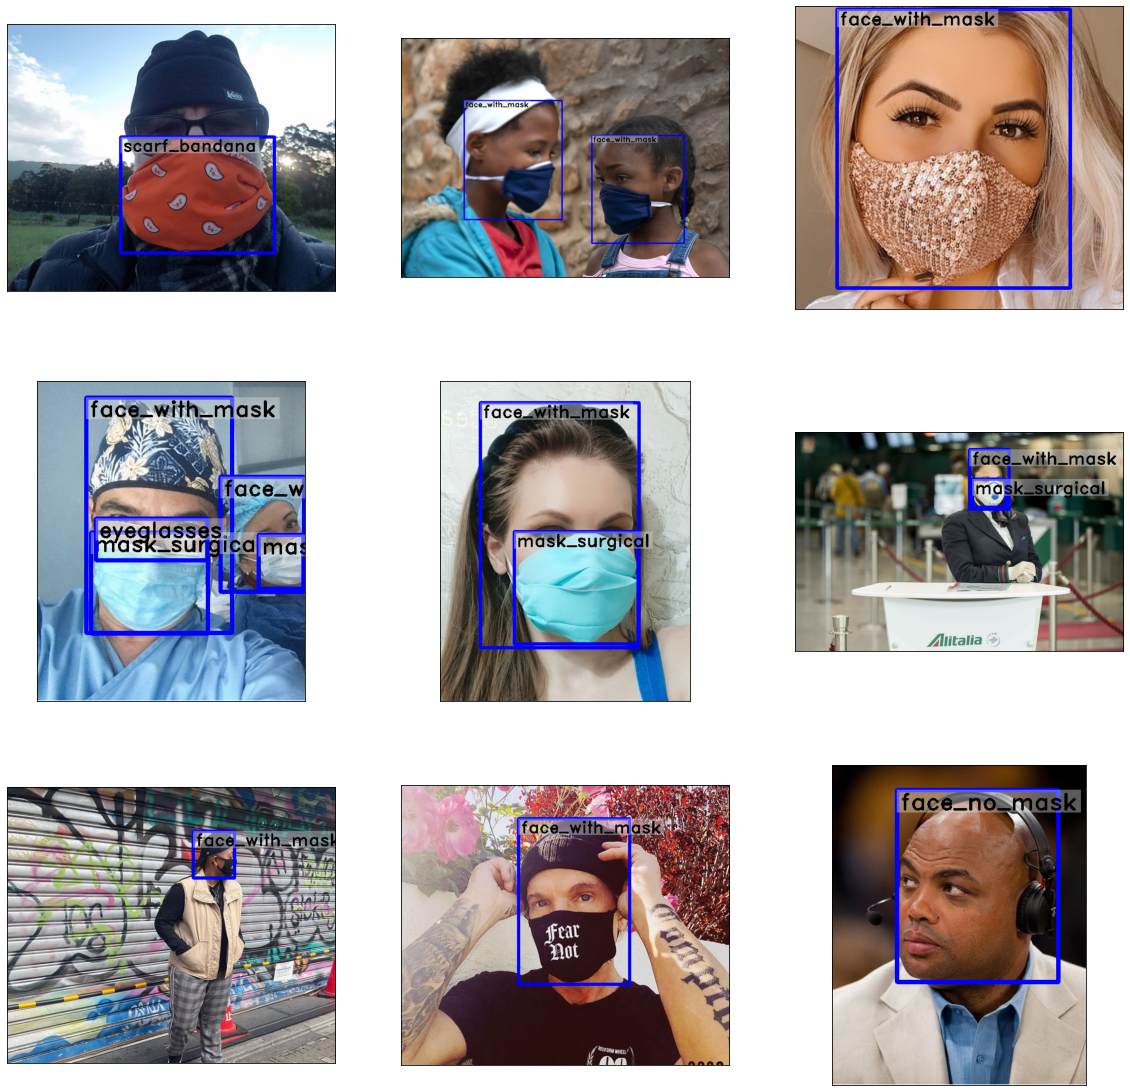

In [47]:
# create a dataset with all images (training + testing)
dataset_full = MaskDataset(root_dir, transformation)

# randomly select 9 images
rand_n = np.random.randint(0, len(dataset_full), 9)
fig = plt.figure(figsize = (20, 20))
idx = 1
print('Sample Images')

for n in rand_n:
  img, labelling = dataset_full[n]
  img = np.array(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()))

  # draw bounding box based on annotations
  for box, label in zip(labelling['boxes'], labelling['labels']):
    x, y, w, h = [int(a) for a in box.tolist()]
    cv2.rectangle(img, (x, y), (w, h), (0, 0, 255), 5)
    img = ps.putBText(img, selected_class[int(label)], text_offset_x=x+5, text_offset_y=y+5, vspace=5, hspace=5, font_scale=1.2, background_RGB=(228,225,222), text_RGB=(1,1,1))
  
  fig.add_subplot(3, 3, idx)
  plt.imshow(img)
  remove_plot_axis(plt)
  idx += 1

plt.show()

In [ ]:
count_list = [0] * 10
count = 0

# loop through every annotation and count amount of instances for every class
for _, labelling in dataset_infer:
  sys.stdout.write(f'\r{count}/{len(dataset_infer)}')
  for a_label in labelling['labels']:
    count_list[int(a_label)] += 1
  count += 1
print()
count_list

3983/3984


[134, 914, 1569, 160, 4180, 149, 55, 192, 2430, 260]

Text(0.5, 1.0, 'Class Distribution')

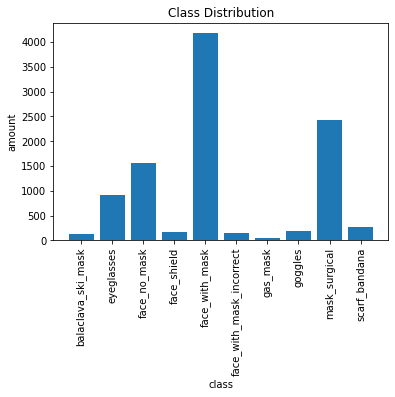

In [ ]:
# plot bar chart to show class distribution
plt.bar(selected_class, count_list)
plt.xticks(rotation=90)
plt.xlabel('class')
plt.ylabel('amount')
plt.title('Class Distribution')

## Optimizer and Schedular
1. Initialize SGD optimizer
2. Initialize schedular with step size of 3 and gamma of 0.1 (learning rate decay 0.1 fold every 3 epochs)

In [10]:
# alocate gpu if it is available else use cpu instead
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Model Training
1. Train model over certain epochs
2. Update learning rate if necessary
3. Evaluate model on testing dataset to check model performance for every epoch

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/698]  eta: 1:12:15  lr: 0.000012  loss: 2.4258 (2.4258)  loss_classifier: 2.2198 (2.2198)  loss_box_reg: 0.1220 (0.1220)  loss_objectness: 0.0732 (0.0732)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 6.2111  data: 4.4989  max mem: 6068
Epoch: [0]  [100/698]  eta: 0:18:33  lr: 0.000729  loss: 0.5472 (0.8852)  loss_classifier: 0.2488 (0.5782)  loss_box_reg: 0.2696 (0.2487)  loss_objectness: 0.0154 (0.0461)  loss_rpn_box_reg: 0.0080 (0.0123)  time: 1.8914  data: 0.5770  max mem: 7937
Epoch: [0]  [200/698]  eta: 0:15:21  lr: 0.001445  loss: 0.3284 (0.6614)  loss_classifier: 0.1375 (0.3828)  loss_box_reg: 0.1840 (0.2374)  loss_objectness: 0.0070 (0.0305)  loss_rpn_box_reg: 0.0058 (0.0106)  time: 1.6433  data: 0.2709  max mem: 8343
Epoch: [0]  [300/698]  eta: 0:11:54  lr: 0.002162  loss: 0.3069 (0.5619)  loss_classifier: 0.1415 (0.3106)  loss_box_reg: 0.1565 (0.2176)  loss_objectness: 0.0066 (0.0239)  loss_rpn_box_reg: 0.0057 (0.0098)  time: 1.7440  data: 0.3917  max mem: 8343


## Model Saving
Save trained model weights in a `.pth` file for later use

In [ ]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'schedular_state_dict': lr_scheduler.state_dict()
            }, 'drive/MyDrive/Dataset/fasterrcnn.pth')

## Model Loading
Function to load trained model if do not want to retrain model again

In [11]:
checkpoint = torch.load(
    'drive/MyDrive/Dataset/fasterrcnn.pth',
    map_location=device
)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

## Model Inference with Testing Dataset
Perform model inference on testing dataset to check how model perform qualitatively.
1. Random select 10 image from testing dataset
2. Make prediction using model trained
3. Print out the prediction result
4. Filter prediction with confidence threshold of 0.7
5. Visualize the original image
6. Visualize the prediction result using matplotlib and pyshine (draw bounding box and write label)
7. Visualize the ground truth for comparison

In [48]:
# random select 10 images
rand_n = np.random.randint(0, len(dataset_test), 10)
model.eval()

for n in rand_n:
  fig = plt.figure(figsize = (17,17))
  img, labelling = dataset_test[n]
  # put the model in evaluation mode
  with torch.no_grad():
      prediction = model([img.to(device)])

  img = np.array(Image.fromarray(dataset_test[n][0].mul(255).permute(1, 2, 0).byte().numpy()))
  img_gt = img.copy()

  # print image information
  print(f'\nIndex: {int(labelling["image_id"][0])}\nFilename: {dataset_test.dataset.imgs[labelling["image_id"]]}')
  pred_str = ''
  for i, box in enumerate(prediction[0]['boxes']):
    pred_str += f'Box: {str(box.int().tolist()):30} Label: {prediction[0]["labels"][i]:<5d}  Score: {prediction[0]["scores"][i]:.2f}\n'
  print(f'Prediction:\n{pred_str}')

  # subplot original image
  fig.add_subplot(1, 3, 1).title.set_text('Original')
  plt.imshow(img)
  remove_plot_axis(plt)

  # Initialize black image of same dimensions for drawing the rectangles
  blk = np.zeros(img.shape, np.uint8)

  # draw bounding boxes and labels for result
  for pre in prediction:
    for i in range(len(pre['boxes'])):
      # filter prediction with low confidence
      if float(pre['scores'][i].cpu()) > 0.7:
        x,y,w,h = pre['boxes'][i]
        label_Y = selected_class[int(pre['labels'].cpu()[i])]
        x, y, w, h = int(x.cpu()), int(y.cpu()), int(w.cpu()), int(h.cpu())
        cv2.rectangle(img, (x, y), (w, h), (0, 0, 255), 5)
        if x + 5 < 0:
          x = 0
        img = ps.putBText(img, label_Y, text_offset_x=x+5, text_offset_y=y+5, vspace=5, hspace=5, font_scale=1.2, background_RGB=(228,225,222), text_RGB=(1,1,1))
  
  # subplot prediction result
  fig.add_subplot(1, 3, 2).title.set_text('Prediction')
  plt.imshow(img)
  remove_plot_axis(plt)

  # draw bounding boxes and labels for ground truth
  for box, label in zip(labelling['boxes'], labelling['labels']):
    x, y, w, h = [int(a) for a in box.tolist()]
    cv2.rectangle(img_gt, (x, y), (w, h), (0, 0, 255), 5)
    img_gt = ps.putBText(img_gt, selected_class[int(label)], text_offset_x=x+5, text_offset_y=y+5, vspace=5, hspace=5, font_scale=1.2, background_RGB=(228,225,222), text_RGB=(1,1,1))

  # subplot ground truth
  fig.add_subplot(1, 3, 3).title.set_text('Ground Truth')
  plt.imshow(img_gt)
  remove_plot_axis(plt)

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Testing Model with Custom Test Set
Test model with custom test sets (own profile image with some photoshop editing)  
There are 6 images tested:
1. Original profile without any face equipment
2. Profile with eyeglasses and surgical face mask
3. Profile with scarf bandana
4. Profile with face shield
5. Profile with goggle
6. Profile with gas mask

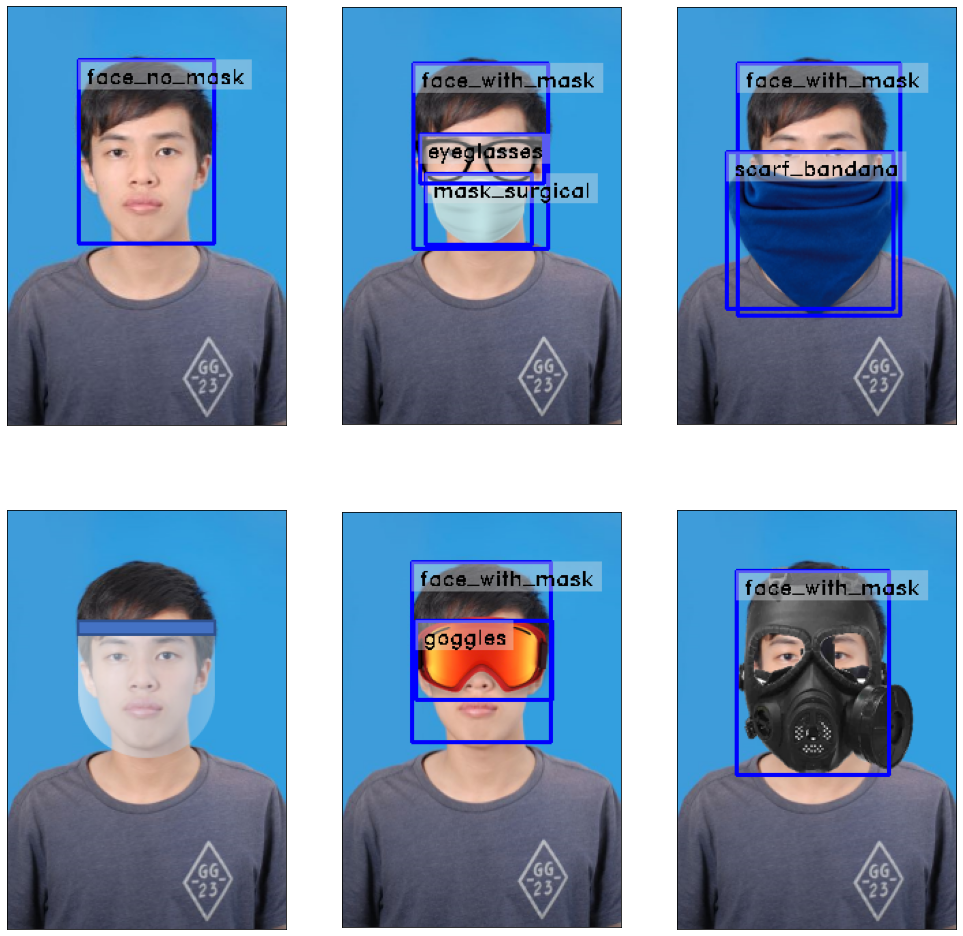

In [42]:
# get all testing images from specified directory
custom_test_list = sorted(os.listdir(root_dir+'custom tests/'))

fig = plt.figure(figsize = (17,17))
idx = 1

for test_name in custom_test_list:
  # model inference
  img = cv2.cvtColor(cv2.imread(root_dir+'custom tests/'+test_name), cv2.COLOR_BGR2RGB)
  model.eval()
  with torch.no_grad():
      prediction = model([torchvision.transforms.ToTensor()(img).to(device)])
  
  # draw bounding box and labels based on prediction result
  for pre in prediction:
    for i in range(len(pre['boxes'])):
      # filter prediction with low confidence
      if float(pre['scores'][i].cpu()) > 0.7:
        x,y,w,h = pre['boxes'][i]
        label_Y = selected_class[int(pre['labels'].cpu()[i])]
        x, y, w, h = int(x.cpu()), int(y.cpu()), int(w.cpu()), int(h.cpu())
        cv2.rectangle(img, (x, y), (w, h), (0, 0, 255), 2)
        if x + 5 < 0:
            x = 0
        img = ps.putBText(img, label_Y, text_offset_x=x+5, text_offset_y=y+5, vspace=5, hspace=5, font_scale=0.5, background_RGB=(228,225,222), text_RGB=(1,1,1), thickness=1)

  fig.add_subplot(2, 3, idx)
  plt.imshow(img)
  remove_plot_axis(plt)

  idx += 1

plt.show()